In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from datetime import datetime
from helpers import *

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")


Using GPU


# Hyperparameters

In [2]:
seq_size = 30 # number of previous days used to predict next day
test_start_date = pd.to_datetime("2023-01-01")
train_start_date = pd.to_datetime("2020-01-01")
out_cols = ['pct_change']
epochs = 25
batch_size = 256
d_model = 64 # number of input features to encoder layer
nhead = 8 # number of heads in multiheadattention
num_layers = 16 # number of encoder layers
dropout = 0.1 # dropout probability

# loading data
data_path = 'data'
interval = '1d'
# companies = os.listdir(data_path)
companies = ['AAPL']
for c in companies:
    if c == 'constituents.csv':
        companies.remove(c)
    elif c == '.DS_Store':
        companies.remove('.DS_Store')

# make unique number for each company ticker
ids = np.linspace(0, 1, len(companies)).round(5)

# Loading Data

In [3]:
def load_data(companies: list, ids: np.array, data_path: str, interval: str, train_start_date: pd.Timestamp, test_start_date: pd.Timestamp,
              out_cols: list, seq_size: int): 
    company_stats = dict() # keys are ticker, values are that company's stat dict
    num_to_ticker = dict()
    ticker_to_num = dict()
    for i, num in enumerate(ids):
        num_to_ticker[str(num)] = companies[i]
        ticker_to_num[companies[i]] = num

    x_train = []
    x_test = []
    y_train = []
    y_test = []
    dates = []

    for co in tqdm(companies):
        files = os.listdir(os.path.join(data_path, co))
        for f in files: # check each company folder for specific interval of data
            if interval in f:
                file = f

        df = pd.read_csv(os.path.join(data_path, co, file))
        df['date'] = pd.to_datetime(df['date'])
        # remove blank column
        df = df.drop(columns=['Unnamed: 0'])
        # remove data before training start date
        df = df[df['date'] >= train_start_date]

        # normalize columns, excluding date column
        df_normed, stat_dict = z_norm(df, 'date')
        # add ticker column
        df_normed['ticker'] = ticker_to_num[co]

        cols = list(df_normed.columns)
        cols.append(cols.pop(cols.index('date'))) # move date to end of list since this will be the order of columns for output df

        # split each df into train and test timeframes
        df_train = df_normed[df_normed['date'] < test_start_date]
        df_test = df_normed[df_normed['date'] >= test_start_date]

        pred_dates = df_test['date'].iloc[seq_size:].tolist()
        dates.append(pred_dates)

        # drop unnecessary columns
        df_train = df_train.drop(columns=['date'])
        df_test = df_test.drop(columns=['date'])

        # store column indices for extracting output features we want
        feature_cols_idx = [list(df_train.columns).index(feature) for feature in out_cols]

        # convert to 2D numpy arrays of shape (-1, num_cols)
        train = df_train.to_numpy()
        test = df_test.to_numpy()

        # convert to sequences and append to respective training and testing lists
        x, y = to_sequences(seq_size, train)
        for i in range(len(x)):
            x_train.append(x[i])
            y_train.append(y[i])
        x, y = to_sequences(seq_size, test)
        for i in range(len(x)):
            x_test.append(x[i])
            y_test.append(y[i])

        company_stats[co] = stat_dict

    indims = y_train[0].shape[0]
    outdims = len(out_cols)
    dates = [element for nestedlist in dates for element in nestedlist]

    x_train = np.vstack(x_train).reshape(-1, seq_size, indims)
    y_train = np.vstack(y_train).reshape(-1, indims)
    x_test = np.vstack(x_test).reshape(-1, seq_size, indims)
    y_test = np.vstack(y_test).reshape(-1, indims)

    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)

    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
    
    return train_loader, test_loader, indims, outdims, dates, company_stats, num_to_ticker, ticker_to_num, feature_cols_idx


train_loader, test_loader, indims, outdims, dates, company_stats, num_to_ticker, ticker_to_num, feature_cols_idx = load_data(companies, ids, data_path, interval, train_start_date, test_start_date, out_cols, seq_size)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Using basic transformer from https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_3_transformer_timeseries.ipynb

In [4]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel(input_dim=indims, output_dim=outdims, d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)

In [5]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

early_stop_count = 0
min_val_loss = float('inf')

for epoch in tqdm(range(epochs)):
    model.train()
    train_losses = []
    for batch in train_loader:
        x_batch, y_batch = batch
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            y_batch = y_batch[:, feature_cols_idx]
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    train_loss = np.mean(train_losses)
    scheduler.step(val_loss)

    #### uncomment below to add early stopping ####

    # if val_loss < min_val_loss:
    #     min_val_loss = val_loss
    #     early_stop_count = 0
    # else:
    #     early_stop_count += 1

    # if early_stop_count >= 5:
    #     print("Early stopping!")
    #     break
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

  0%|          | 0/25 [00:00<?, ?it/s]c:\Users\oraga\anaconda3\envs\stocks\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
  4%|▍         | 1/25 [00:09<03:50,  9.60s/it]

Epoch 1/25, Train Loss: 4.1932, Validation Loss: 0.3461


  8%|▊         | 2/25 [00:18<03:34,  9.32s/it]

Epoch 2/25, Train Loss: 1.4563, Validation Loss: 0.5314


 12%|█▏        | 3/25 [00:27<03:20,  9.13s/it]

Epoch 3/25, Train Loss: 1.3497, Validation Loss: 0.4197


 16%|█▌        | 4/25 [00:36<03:10,  9.05s/it]

Epoch 4/25, Train Loss: 1.3056, Validation Loss: 0.3477


 20%|██        | 5/25 [00:45<02:59,  8.97s/it]

Epoch 5/25, Train Loss: 1.2538, Validation Loss: 0.3588


 24%|██▍       | 6/25 [00:54<02:50,  8.97s/it]

Epoch 6/25, Train Loss: 1.2670, Validation Loss: 0.3583


 28%|██▊       | 7/25 [01:03<02:40,  8.92s/it]

Epoch 7/25, Train Loss: 1.2588, Validation Loss: 0.3453


 32%|███▏      | 8/25 [01:11<02:30,  8.88s/it]

Epoch 8/25, Train Loss: 1.2600, Validation Loss: 0.3490


 36%|███▌      | 9/25 [01:20<02:21,  8.86s/it]

Epoch 9/25, Train Loss: 1.2578, Validation Loss: 0.3465


 40%|████      | 10/25 [01:29<02:12,  8.84s/it]

Epoch 10/25, Train Loss: 1.2397, Validation Loss: 0.3478


 44%|████▍     | 11/25 [01:38<02:03,  8.84s/it]

Epoch 11/25, Train Loss: 1.2310, Validation Loss: 0.3496


 48%|████▊     | 12/25 [01:47<01:55,  8.88s/it]

Epoch 12/25, Train Loss: 1.2647, Validation Loss: 0.3469


 52%|█████▏    | 13/25 [01:56<01:46,  8.84s/it]

Epoch 13/25, Train Loss: 1.2473, Validation Loss: 0.3452


 56%|█████▌    | 14/25 [02:04<01:37,  8.83s/it]

Epoch 14/25, Train Loss: 1.2442, Validation Loss: 0.3463


 60%|██████    | 15/25 [02:13<01:28,  8.82s/it]

Epoch 15/25, Train Loss: 1.2625, Validation Loss: 0.3453


 64%|██████▍   | 16/25 [02:22<01:19,  8.83s/it]

Epoch 16/25, Train Loss: 1.2381, Validation Loss: 0.3469


 68%|██████▊   | 17/25 [02:31<01:10,  8.86s/it]

Epoch 17/25, Train Loss: 1.2263, Validation Loss: 0.3461


 72%|███████▏  | 18/25 [02:40<01:02,  8.86s/it]

Epoch 18/25, Train Loss: 1.2484, Validation Loss: 0.3452


 76%|███████▌  | 19/25 [02:49<00:53,  8.83s/it]

Epoch 19/25, Train Loss: 1.2451, Validation Loss: 0.3455


 80%|████████  | 20/25 [02:58<00:44,  8.84s/it]

Epoch 20/25, Train Loss: 1.2562, Validation Loss: 0.3453


 84%|████████▍ | 21/25 [03:06<00:35,  8.83s/it]

Epoch 21/25, Train Loss: 1.2423, Validation Loss: 0.3452


 88%|████████▊ | 22/25 [03:15<00:26,  8.90s/it]

Epoch 22/25, Train Loss: 1.2638, Validation Loss: 0.3457


 92%|█████████▏| 23/25 [03:25<00:18,  9.01s/it]

Epoch 23/25, Train Loss: 1.2362, Validation Loss: 0.3457


 96%|█████████▌| 24/25 [03:33<00:08,  8.96s/it]

Epoch 24/25, Train Loss: 1.2382, Validation Loss: 0.3456


100%|██████████| 25/25 [03:42<00:00,  8.91s/it]

Epoch 25/25, Train Loss: 1.2448, Validation Loss: 0.3455


In [ ]:
saved_weights_path = 'saved_models'
fn = f'AAPL_model_{datetime.now().strftime("%Y%m%d")}.pt'

In [ ]:
torch.save(model.state_dict(), os.path.join(saved_weights_path, fn))

# Testing

In [6]:
# testing with metrics
# model = TransformerModel(input_dim=indims, output_dim=outdims).to(device)
# model.load_state_dict(torch.load(os.path.join(saved_weights_path, "AAPL_model_20240209.pt")))
results = []
gt_preds = []
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):
        x_batch, y_batch = batch
        tickers = [num_to_ticker[str(y_batch.detach().numpy()[idx,-1])] for idx in range(y_batch.shape[0])]
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)

        gt_outputs = process_results(y_batch, batch_size, i, dates, tickers)
        processed_outputs = process_results(outputs, batch_size, i, dates, tickers)

        [results.append(out) for out in processed_outputs]
        [gt_preds.append(out) for out in gt_outputs]

columns = [ele for nested in [out_cols, ['ticker', 'date']] for ele in nested]
df_pred = pd.DataFrame(results, columns=columns)
df_gt = pd.DataFrame(gt_preds, columns=columns)
for co in companies:
    df_pred[df_pred['ticker'] == co] = reverse_z_norm(df_pred, company_stats[co], col_exclude=['ticker', 'date'])
    df_gt[df_pred['ticker'] == co] = reverse_z_norm(df_gt, company_stats[co], col_exclude=['ticker', 'date'])

df_pred = rename_cols(df_pred, '_pred', ['date', 'ticker'])
df_gt = rename_cols(df_gt, '_gt', ['date', 'ticker'])
df_merged = pd.merge(df_pred, df_gt, 'inner')

1it [00:04,  4.40s/it]


In [7]:
df_merged.head()

,pct_change_pred,ticker,date,pct_change_gt
0,0.001262,AAPL,2023-02-15,0.013903
1,0.001262,AAPL,2023-02-16,-0.010429
2,0.001262,AAPL,2023-02-17,-0.007547
3,0.001262,AAPL,2023-02-21,-0.026680
4,0.001262,AAPL,2023-02-22,0.002896


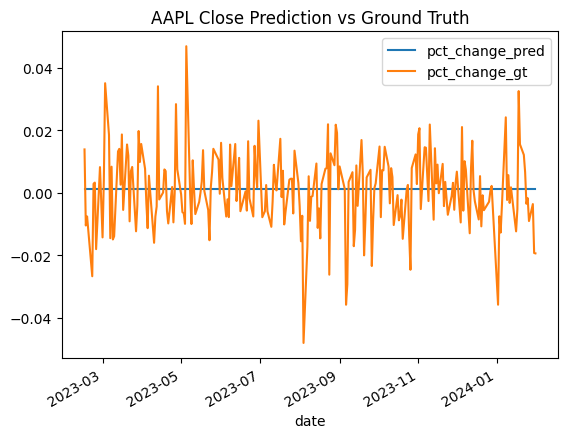

In [9]:
df_merged[df_merged['ticker'] == 'AAPL'].plot(x='date', y=['pct_change_pred', 'pct_change_gt'])
plt.legend()
plt.title(f"AAPL Close Prediction vs Ground Truth")
plt.show()

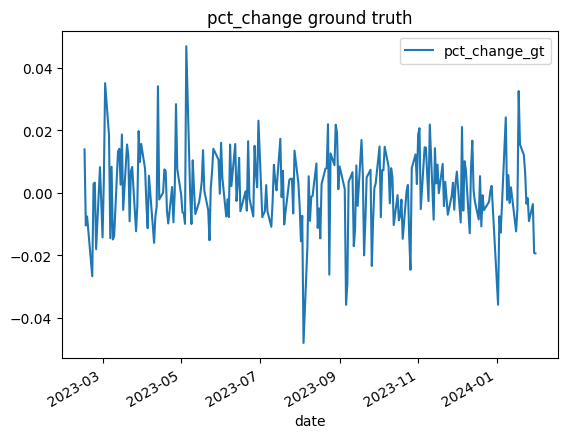

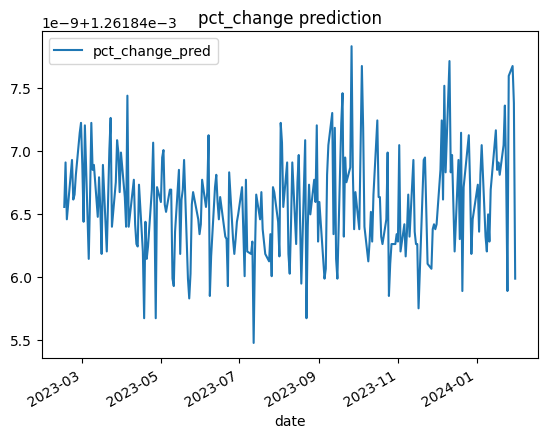

In [15]:
df_merged[df_merged['ticker'] == 'AAPL'].plot(x='date', y='pct_change_gt')
plt.title("pct_change ground truth")
plt.show()
df_merged[df_merged['ticker'] == 'AAPL'].plot(x='date', y='pct_change_pred')
plt.title("pct_change prediction")
plt.show()

In [11]:
accuracy_metrics = dict()
for i in tqdm(range(len(companies))):
    gt_rows = df_merged[df_merged["ticker"] == companies[i]]["pct_change_gt"]
    pred_rows = df_merged[df_merged["ticker"] == companies[i]]["pct_change_pred"]
    accuracy_metrics[companies[i]] = directional_accuracy_pct_change(gt_rows, pred_rows)

100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


In [12]:
accuracy_metrics

{'AAPL': 0.5269709543568465}